/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_89981/231264077.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(Observation[:, obs]).requires_grad_(True)


tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000, 0.5000],
        [0.9900, 0.9900, 0.0100, 0.0000, 0.0000, 0.0100, 0.0000]],
       requires_grad=True)


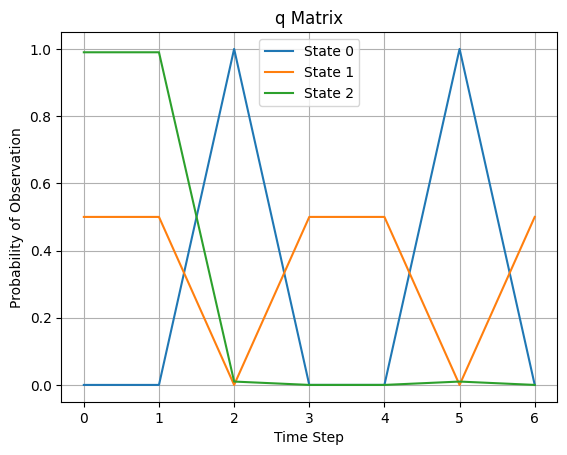

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import params

states = torch.tensor([0, 1, 2])
Transition = torch.tensor([[0, 1/2, 1/2],
                           [1/2, 0, 1/2],
                           [1/2, 1/2, 0]])
obs = torch.tensor([0, 0, 2, 1, 1, 2, 1])
Observation = torch.tensor([[0, 1/2, .99],
                            [0, 1/2, 0],
                            [1, 0, .01]]).T
Duration = torch.tensor([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]])

def q_matrix(obs, Observation):
    return torch.tensor(Observation[:, obs]).requires_grad_(True)

q = q_matrix(obs, Observation)
print(q)

# plot
time_steps = range(len(obs))
plt.figure()
for state in states:
    probs = [q[state][i].detach().numpy() for i in range(len(obs))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([-29.9336,  -0.6931, -29.9336], grad_fn=<SumBackward1>)
tensor([  0.0000, -29.9336,  -4.6052], grad_fn=<SumBackward1>)
tensor([-29.9336, -30.6268, -34.5388], grad_fn=<SumBackward1>)
tensor([-29.9336,  -0.6931, -29.9336], grad_fn=<SumBackward1>)
tensor([-29.9336, -30.6268, -34.5388], grad_fn=<SumBackward1>)
tensor([-59.8672, -31.3199, -64.4724], grad_fn=<SumBackward1>)
tensor([-29.9336,  -0.6931, -29.9336], grad_fn=<SumBackward1>)
tensor([-59.8672,  -1.3863, -59.8672], grad_fn=<SumBackward1>)
tensor([-59.8672, -31.3199, -64.4724], grad_fn=<SumBackward1>)
tensor([  0.0000, -29.9336,  -4.6052], grad_fn=<SumBackward1>)
tensor([-29.9336, -30.6268, -34.5388], grad_fn=<SumBackward1>)
tensor([-59.8672, -31.3199, -64.4724], grad_fn=<SumBackward1>)
tensor([-2.9934e+01, -6.9315e-01, -1.0050e-02], grad_fn=<SumBackward1>)
tensor([-29.9336, -30.6268,  -4.6152], grad_fn=<SumBackward1>)
tensor([-59.8672, -31.3199, -34.5488], grad_fn=<SumBackward1>)


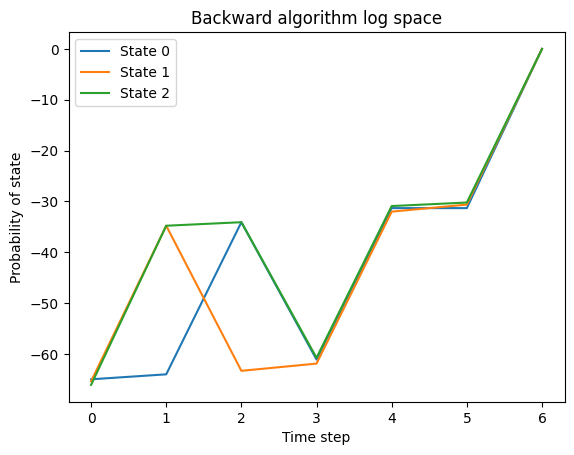

In [23]:
# original
def backward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    epsilon = 1e-13
    log_beta = torch.full((T, N), -float('inf'))

    # initialization, log_beta[-1]
    log_beta_new = log_beta.clone()
    log_beta_new[-1] = torch.zeros(N)
    log_beta = log_beta_new

    # fill log_beta[:-1]
    for t in tqdm.trange(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T - 2:
                log_beta_new = log_beta.clone()
                log_beta_new[t] = torch.logaddexp(log_beta[t], 
                                                  torch.logsumexp(
                                                      torch.row_stack([log_beta[t+d+1]]*N)
                                                      + torch.log(Transition + epsilon)
                                                      + torch.log(torch.row_stack([Duration[:, d]]*N) + epsilon) 
                                                      + torch.sum(torch.log(q[:, t + 1:t + d + 2] + epsilon), axis=1), 
                                                                  axis=1))
                print((torch.sum(torch.log(q[:, t + 1:t + d + 2] + epsilon), axis=1)))
                log_beta = log_beta_new
                
    log_beta = torch.exp(log_beta)
    log_beta_sum = torch.sum(log_beta)
    # log_beta_sum.backward()

    return log_beta

bwd = backward(states, Transition, q, Duration).detach().numpy()

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(q[0]))]
    plt.plot(range(len(q[0])), np.log(probs), label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

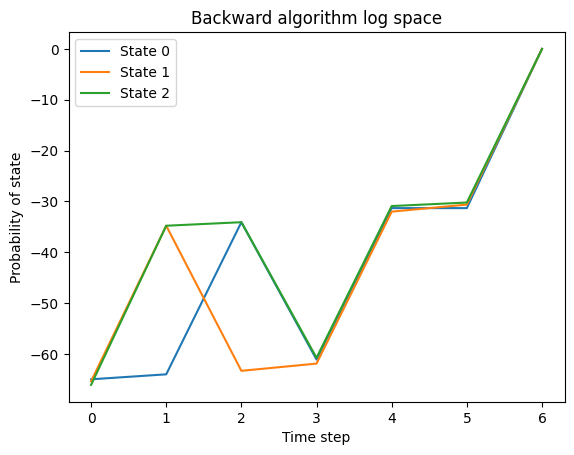

In [39]:
def backward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    epsilon = 1e-13
    log_beta = torch.full((T, N), -float('inf'))

    Transition_ep = torch.log(Transition + epsilon)
    Duration_ep = torch.log(Duration + epsilon)
    q_ep = q + epsilon

    cum_q_ep = torch.flip(torch.cumsum(torch.flip(torch.log(q_ep), dims=[1]), dim=1), dims=[1])


    # initialization, log_beta[-1]
    log_beta[-1] = torch.zeros(N)

    # fill log_beta[:-1]
    for t in tqdm.trange(T - 2, -1, -1):
        # cumulative_terms = cum_q_ep[:, t+1]
        for d in range(D):
            if t+d <= T-2:
                cumulative_terms = cum_q_ep[:, t+1] if t+d+1 >= T-1 else cum_q_ep[:, t+1] - cum_q_ep[:, t+d+2]
                log_beta[t] = torch.logaddexp(log_beta[t],
                                                torch.logsumexp(
                                                    torch.row_stack([log_beta[t+d+1]]*N)
                                                    + Transition_ep
                                                    + Duration_ep[:, d]
                                                    + cumulative_terms, axis=1))
            else:
                break

    log_beta = torch.exp(log_beta)
    return log_beta

bwd = backward(states, Transition, q, Duration).detach().numpy()

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(q[0]))]
    plt.plot(range(len(q[0])), np.log(probs), label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

In [37]:
import torch

# Example 2D tensor
tensor = torch.tensor([[1, 2, 3, 4, 5], 
                       [6, 7, 8, 9, 10]])

# Flip the columns (reverse the order of columns)
flipped_tensor = torch.flip(tensor, dims=[1])

# To demonstrate the output
print("Original Tensor:\n", tensor)
print("Flipped Tensor (Columns Reversed):\n", flipped_tensor)

# Compute the cumulative sum on the reversed tensor
cumsum_reversed = torch.cumsum(flipped_tensor, dim=1)

# Reverse the cumsum result to get the final output
result_tensor = torch.flip(cumsum_reversed, dims=[1])

# To demonstrate the output
print("Flipped Cumulative Sum Tensor:\n", cumsum_reversed)
print("Result Tensor:\n", result_tensor)

Original Tensor:
 tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]])
Flipped Tensor (Columns Reversed):
 tensor([[ 5,  4,  3,  2,  1],
        [10,  9,  8,  7,  6]])
Flipped Cumulative Sum Tensor:
 tensor([[ 5,  9, 12, 14, 15],
        [10, 19, 27, 34, 40]])
Result Tensor:
 tensor([[15, 14, 12,  9,  5],
        [40, 34, 27, 19, 10]])
